In [1]:
from matplotlib import pyplot as plt


In [2]:
import artm

In [3]:
#   Считывание данных и их преобразование
#   Формат - это data_format @vowpal_wabbit" - удобный для визуального понимания
#   batch_size - сколько строк пойдет в один файл
batch_vectorizer = artm.BatchVectorizer(data_path='school.txt', data_format='vowpal_wabbit',
                                        target_folder='school_batches',
                                        batch_size=100)

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#   После преобразование данные можно считывать из батчей

batch_vectorizer = artm.BatchVectorizer(data_path='school_batches', data_format='batches')

In [5]:
#   Создаем объект класса artm
#   Количество тем
T = 10
#   class_id - веса модальностей (разные типы классов документов)
#   seed - нужен для инициализации словаря
#   Можно бахнуть document_passes - чтобы больше гулять по документам
model_artm = artm.ARTM(num_topics=T, topic_names=["theme_" + str(i) for i in range(T)], class_ids={'text':1},
                       seed=-1, num_document_passes=1, reuse_theta=True, cache_theta=True)

In [6]:
#   Нужно создать метрики для того чтобы оценивать модель
#   Сначала перпрексия
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                      dictionary = 'dictionary'))
#   Метрики разреженности матриц тета и фи
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore',
                                            class_id='text'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
#   топ слов входящих в тему. Num_tokens - сколько топовых слов
model_artm.scores.add(artm.TopTokensScore(name='top words', num_tokens=15, class_id='text'))

In [7]:
#   Создаем словарь и инициализируем его
#   Ранее в модели указывали сид для того чтобы воспроизводить начальные приближения матриц фи и тета
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('dictionary')

In [8]:
#   Строим модель. Offline - проходит по коллекции много раз. Земля пухом если выборка большая
#   Сколько раз гулять ставим в num_collection_passes
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


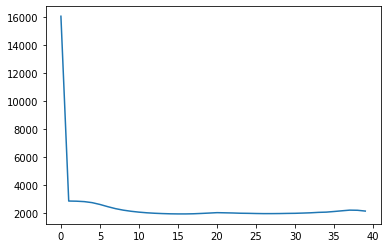

In [9]:
#   Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.
plt.plot(model_artm.score_tracker['PerplexityScore'].value)


In [10]:
#   Посмотрим какие получились топы слов

for topic_name in model_artm.topic_names:
    print(f'topic_name "{topic_name}":')
    tokens = model_artm.score_tracker["top words"].last_tokens
    for word in model_artm.score_tracker['top words'].last_tokens[topic_name]:
        print(f'{word}', end=' ')
    print('\n')

topic_name "theme_0":
который быть что это человек этот как свой для они его весь такой время себя 

topic_name "theme_1":
возведение a b множитель раскладывать x выражение умножение скобка разложение сокращенный квадрат ответ переменный целый 

topic_name "theme_2":
обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня оборот вера браслет старик сантьяго 

topic_name "theme_3":
который быть год свой время государство человек мир становиться северный жизнь первый война африка ребенок 

topic_name "theme_4":
x a b уравнение дробь квадратный y степень функция число f решение корень c пример 

topic_name "theme_5":
быть год пушкин функция свой его русский который поэт империя a культура весь f трение 

topic_name "theme_6":
сила быть тело энергия поле при магнитный точка географический наречие если частица например заряд величина 

topic_name "theme_7":
который что это как человек для этот такой быть являться мочь себя она его свой 

topic_name "t

In [11]:
#   Посмотрим на разреженность матриц
#   Показывает долю нулей
print(f"SparsityPhi:{model_artm.score_tracker['SparsityPhiScore'].last_value}")
print(f"SparsityTheta:{model_artm.score_tracker['SparsityThetaScore'].last_value}")

SparsityPhi:0.7333747148513794
SparsityTheta:0.1655462235212326


In [12]:
#   Если посмотреть на слова - то видно очень много мусора из общеупотребляемых слов.
#   Нужно их убрать
#   Будем использовать регуляризатор матрицы фи
#   При указании словаря tau умножается на частоту слова, если словарь не указывать идет умножение веса слова

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100,
                                                            dictionary='dictionary',
                                                            ))

In [13]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [14]:
for topic_name in model_artm.topic_names:
    print(f'topic_name "{topic_name}":')
    tokens = model_artm.score_tracker['top words'].last_tokens
    try:
        for word in model_artm.score_tracker['top words'].last_tokens[topic_name]:
            print(f'{word}', end=' ')
    except:
        print('Null Theme')
    print('\n')

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_name "theme_0":
который быть что это этот как человек свой для они весь такой его время год 

topic_name "theme_1":
Null Theme


topic_name "theme_2":
обособление куприн слово раскольников мастер роман словосочетание маргарита браслет подчинительный соня оборот вера управление зависимое 

topic_name "theme_3":
который быть год для этот что как свой это они весь государство человек время такой 

topic_name "theme_4":
x a b число уравнение корень дробь функция y квадратный степень f решение получать пример 

topic_name "theme_5":
быть функция пушкин точка трение a f год предложение империя область существительное звук пример язык 

topic_name "theme_6":
магнитный индукция поле наречие примыкать местоимение прилагательный существительный генератор сторонний контур крепко отдыхать магазин дизельный 

topic_name "theme_7":
что человек это как его свой она герой мочь другой себя который сила образ при 

topic_name "theme_8":
быть который что это этот как свой для человек x они такой го

In [33]:
#   Нужно менять коэффициент регуляризации
model_artm.regularizers['SparsePhi'].tau = -5*1e4
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

In [34]:
for topic_name in model_artm.topic_names:
    print(f'Theme:{topic_name} top words:')
    tokens = model_artm.score_tracker["top words"].last_tokens
    try:
        for word in tokens[topic_name]:
            print(f'{word}', end=' ')
    except:
        continue
    print('\n')

Theme:theme_0 top words:
предложение вода корень древний квадратный дом n океан жить собственный крестьянин член александр зона достигать 

Theme:theme_1 top words:
Theme:theme_2 top words:
Theme:theme_3 top words:
северный африка ресурс сфера географический конфликт климат цивилизация международный ядерный гражданин материк остров организация среда 

Theme:theme_4 top words:
Theme:theme_5 top words:
функция пушкин империя f определение область промежуток восстание трение существительное английский пояс павел падеж оборот 

Theme:theme_6 top words:
Theme:theme_7 top words:
лермонтов поэма толстой правило иван лиза мертвый общение средство хотеть детство относительно поведение ничто одиночество 

Theme:theme_8 top words:
x a два b ребенок город равный уравнение сторона y движение условие различный решение поле 

Theme:theme_9 top words:
который быть что это этот человек как свой для такой они весь его год жизнь 



In [30]:
print(f"SparsityPhi:{model_artm.score_tracker['SparsityPhiScore'].last_value}")
print(f"SparsityTheta:{model_artm.score_tracker['SparsityThetaScore'].last_value}")

SparsityPhi:0.9119821190834045
SparsityTheta:0.5050420165061951


In [ ]:
#   Сохранение модели
#model_artm.save('save_model')
#   Загрузка модели
#model_artm.load('save_model')

In [37]:
#   Запрос матриц
#model_artm.get_phi()
#model_artm.get_theta()

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,400,401,402,403,404,405,406,407,408,409,...,190,191,192,193,194,195,196,197,198,199
theme_0,0.070946,0.052567,0.037453,0.035938,0.038462,0.155172,0.194030,0.029520,0.050676,0.081897,...,0.020833,0.170124,0.104430,0.176471,0.090592,0.094697,0.096429,0.131868,0.036232,0.074713
theme_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
theme_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
theme_3,0.003378,0.008547,0.026217,0.002882,0.025641,0.005747,0.009950,0.000000,0.030405,0.000000,...,0.029167,0.182293,0.246835,0.068857,0.041812,0.105359,0.096429,0.043956,0.028985,0.000000
theme_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
theme_5,0.074324,0.307021,0.224719,0.638414,0.145299,0.057471,0.124378,0.022140,0.087838,0.379310,...,0.004167,0.045643,0.025316,0.048443,0.027875,0.030303,0.064286,0.040293,0.003749,0.005747
theme_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
theme_7,0.003378,0.027158,0.007491,0.008646,0.038462,0.017241,0.039801,0.000000,0.006757,0.008621,...,0.133024,0.004149,0.041113,0.017301,0.006969,0.041667,0.010714,0.010989,0.238554,0.040230
theme_8,0.087838,0.073783,0.123596,0.066282,0.034188,0.500000,0.109453,0.059041,0.040541,0.030172,...,0.075310,0.107884,0.085469,0.110727,0.118467,0.087121,0.085714,0.267399,0.051176,0.477012
theme_9,0.760135,0.530923,0.580524,0.247838,0.717949,0.264368,0.522388,0.889299,0.783784,0.500000,...,0.737500,0.489906,0.496836,0.578202,0.714286,0.640853,0.646429,0.505495,0.641304,0.402299


In [ ]:
#   Анализ новых документов
#model_artm.transform(batch_vectorizer=new_batch_vectorizer)